파일 불러오기

In [1]:
import matplotlib.pyplot as plt

# Plotting
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
plt.show()

In [2]:
import pandas as pd
# # 한국경제

df = pd.read_csv("./csv/hangyoung.csv", 
                 usecols=['date', 'sent_score'], 
                 parse_dates=['date'])

## 매일경제

# df = pd.read_csv("./csv/mail_finish_.csv", 
#                  usecols=['date', 'senti'], 
#                  parse_dates=['date'])
# df.rename(columns={'senti': 'sent_score'}, inplace=True)

# # 블롬버그
# df = pd.read_csv("./csv/bloomberg.csv", 
#                  usecols=['date', 'senti'], 
#                  parse_dates=['date'])
# df.rename(columns={'senti': 'sent_score'}, inplace=True)

# 종합
# df = pd.read_csv("C:/Users/82107/Desktop/동아리/14기/mvo/학술제/granger/그래인저 최종.csv", 
#                  usecols=['Date', 'sent_index'], 
#                  parse_dates=['Date'],encoding='cp949')
# df.rename(columns={'sent_index': 'sent_score'}, inplace=True)
# df.rename(columns={'Date': 'date'}, inplace=True)
# df['date'] = pd.to_datetime(df['date'],format = '%b-%y')

# #섹터별
# df = pd.read_csv("C:/Users/82107/Desktop/동아리/14기/mvo/학술제/csv/섹터별 감성지수/경기.csv", 
#                  usecols=['date', 'senti'], 
#                  parse_dates=['date'])
# df.rename(columns={'senti': 'sent_score'}, inplace=True)

df_senti_date = df.groupby('date').mean().reset_index()
df_senti_month = df.groupby(pd.Grouper(key='date', freq='M')).mean().reset_index()
df_senti_month['date'] = df_senti_month['date'] - pd.DateOffset(months=1)
month_test = 12
for i in range(month_test, len(df_senti_month)):
    S_t_1 = df_senti_month.loc[i, 'sent_score']
    previous_3_months = df_senti_month.loc[i-month_test:i-1, 'sent_score']
    max_prev = previous_3_months.max()
    min_prev = previous_3_months.min()
    
    if S_t_1 > max_prev:
        adjustment_factor = 1
    elif S_t_1 < min_prev:
        adjustment_factor = 0
    else:
        adjustment_factor = (S_t_1 - min_prev) / (max_prev - min_prev)
    
    df_senti_month.loc[i, 'norm_senti'] = adjustment_factor

print(df_senti_month)

         date  sent_score  norm_senti
0  2016-06-30    1.200000         NaN
1  2016-07-31    4.677419         NaN
2  2016-08-30   -2.285714         NaN
3  2016-09-30   -0.307692         NaN
4  2016-10-30    0.033333         NaN
..        ...         ...         ...
90 2023-12-31   -0.194030    0.125679
91 2024-01-29    2.156250    0.464171
92 2024-02-29    3.040323    0.591497
93 2024-03-30    1.924242    0.430757
94 2024-04-30    6.236842    1.000000

[95 rows x 3 columns]


C:\Users\82107\AppData\Local\Temp\ipykernel_34732\4188293631.py:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_senti_month = df.groupby(pd.Grouper(key='date', freq='M')).mean().reset_index()


In [3]:
import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice,seed 
from numpy.linalg import inv
import seaborn as sns
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
df_return = pd.read_excel("./csv/month_return.xlsx", index_col=0, parse_dates=True)/100
randomseed = 42
def mvo(df):
    #파라미터 셋팅
    stocks = df.columns
    n_obs, n_assets = df.shape
    NUM_PF = 100000 #number of portfolios to simulate

    #연단위 환산
    periods_per_year = round(df.resample('YE').size().mean())
    periods_per_year #전체 기간을 1년 단위로 환산

    #평균 수익률 및 covariance-variance matrix
    mean_returns = (1+df.mean())** periods_per_year - 1
    cov_matrix = df.cov()
    #precision matrix는 covariance matrix의 inverse matrix
    precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks) 
    precision_matrix
    rf_rate = 0
    def portfolio_std(wt, rt=None, cov=None):
        return np.sqrt(wt @ cov @ wt * periods_per_year)

    def portfolio_returns(wt, rt=None, cov=None):
        return (wt @ rt + 1) ** periods_per_year -1

    def portfolio_performance(wt, rt, cov):
        r = portfolio_returns(wt, rt=rt)
        sd = portfolio_std(wt, cov=cov)
        return r, sd
        
    #minimize function
    def neg_sharpe_ratio(weights, mean_ret, cov):
        r, sd = portfolio_performance(weights, mean_ret, cov)
        return -(r - rf_rate) / sd

    def max_sharpe_ratio(mean_ret, cov, short=False):
        seed(randomseed)
        x0 = uniform(0, 1, n_assets) #초기값
        x0 /= np.sum(np.abs(x0))

        return minimize(fun=neg_sharpe_ratio, #제약식
                        x0=x0, #초기값
                        args=(mean_ret, cov),
                        method='SLSQP',
                        bounds=((0, 1),) * n_assets, #weight가 0,1 사이에 오도록
                        constraints = {'type':'eq','fun': lambda x: np.sum(np.abs(x))-1}, #weight의 합이 1
                        options={'maxiter':1e4}) #최대 반복 횟수
                        
    # get max sharpe PF
    max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
    max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)
    # print(f'최적 sharp_ratio의 weight = \n{max_sharpe_pf.x}, \nreturn, std = {max_sharpe_perf}')

    return max_sharpe_pf.x, max_sharpe_perf[0], max_sharpe_perf[1]


def mvo_rf(df):
    #파라미터 셋팅
    stocks = df.columns
    n_obs, n_assets = df.shape
    NUM_PF = 100000 #number of portfolios to simulate


    #연단위 환산
    periods_per_year = round(df.resample('YE').size().mean())
    periods_per_year #전체 기간을 1년 단위로 환산

    #평균 수익률 및 covariance-variance matrix
    mean_returns = (1+df.mean())** periods_per_year - 1
    cov_matrix = df.cov() 
    #precision matrix는 covariance matrix의 inverse matrix
    precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks) 
    precision_matrix
    rf_rate = 0.035
    def portfolio_std(wt, rt=None, cov=None):
        asset_weights = wt[:-1]
        return np.sqrt(asset_weights @ cov @ asset_weights * periods_per_year)

    def portfolio_returns(wt, rt=None, cov=None):
        asset_weights = wt[:-1]
        rf_weight = wt[-1]
        return ((asset_weights @ rt + rf_weight * rf_rate + 1) ** periods_per_year) - 1


    def portfolio_performance(wt, rt, cov):
        r = portfolio_returns(wt, rt=rt)
        sd = portfolio_std(wt, cov=cov)
        return r, sd
        
    #minimize function
    def neg_sharpe_ratio(weights, mean_ret, cov):
        r, sd = portfolio_performance(weights, mean_ret, cov)
        if sd == 0:
            return float('inf')  # 혹은 원하는 다른 값을 반환
        return -(r - rf_rate) / sd
    
    def max_sharpe_ratio(mean_ret, cov, short=False):
        seed(randomseed)
        x0 = uniform(0, 1, n_assets+1) #초기값
        x0 /= np.sum(np.abs(x0))

        return minimize(fun=neg_sharpe_ratio,  # 제약식
                        x0=x0,  # 초기값
                        args=(mean_ret, cov),
                        method='SLSQP',
                        bounds=((0, 1),) * (n_assets + 1),  # weight가 0,1 사이에 오도록
                        constraints={'type': 'eq', 'fun': lambda x: np.sum(np.abs(x)) - 1},  # weight의 합이 1
                        options={'maxiter': 1e4})  # 최대 반복 횟수

                        
    # get max sharpe PF
    max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
    max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)
    # print(f'최적 sharp_ratio의 weight = \n{max_sharpe_pf.x}, \nreturn, std = {max_sharpe_perf}')

    return max_sharpe_pf.x, max_sharpe_perf[0], max_sharpe_perf[1]


weight, sharpe, std = mvo_rf(df_return)
weight

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.52685970e-01,
       0.00000000e+00, 0.00000000e+00, 6.47314030e-01, 3.58208045e-13])

백테스트 코드

In [4]:
def backtest(df, weights, risk_free_weight, start_date, risk_free_rate):
    start_date = pd.to_datetime(start_date)
    end_date = start_date + pd.DateOffset(months=1)

    df = df[(df.index >= start_date) & (df.index <= end_date)]
    initial_value = 1.0
    portfolio_value = initial_value
    weights = [w * (1 - risk_free_weight) for w in weights]
    weights.append(risk_free_weight)
    daily_risk_free_rate = (1 + risk_free_rate) ** (1/(12)) - 1  
    for date in df.index:
        daily_returns = df.loc[date].values
        daily_returns = list(daily_returns) + [daily_risk_free_rate]
        portfolio_return = sum([weights[i] * daily_returns[i] for i in range(len(weights))])
        portfolio_value *= (1 + portfolio_return)
    
    total_return = (portfolio_value / initial_value - 1) * 100
    return total_return

def backtest2(df, weights, risk_free_weight, start_date, risk_free_rate):
    start_date = pd.to_datetime(start_date)
    end_date = start_date + pd.DateOffset(months=1)

    df = df[(df.index >= start_date) & (df.index <= end_date)]
    initial_value = 1.0
    portfolio_value = initial_value
    daily_risk_free_rate = (1 + risk_free_rate) ** (1/(12)) - 1  
    
    for date in df.index:
        daily_returns = df.loc[date].values
        daily_returns = list(daily_returns) + [daily_risk_free_rate]
        
        portfolio_return = sum([weights[i] * daily_returns[i] for i in range(len(weights))])
        portfolio_value *= (1 + portfolio_return)
    
    total_return = (portfolio_value / initial_value - 1) * 100
    return total_return

몬테카를로(사용 X)

In [56]:
# df_return = pd.read_excel("./csv/month_return.xlsx", index_col=0, parse_dates=True)/100
# ss = np.random.SeedSequence()
# rng = np.random.default_rng(ss)
# # 몬테 카를로 법칙을 이용한 weight 뽑기 함수
# def weight_select(n_iterations, weight_range, evaluate_model):
#     best_weight = None
#     best_score = float('-inf')
#     scores =[]
#     for _ in range(n_iterations):
#         weight1 = rng.uniform(weight_range[0], weight_range[1])
#         weight2 = rng.uniform(weight_range[0], 1- weight1)
#         weight3 = 1-weight1-weight2
#         score = evaluate_model(weight1,weight2,weight3)
        
#         if score > best_score:
#             best_score = score
#             best_weight = [weight1,weight2,weight3]
#         scores.append(best_score)
#     return best_weight, best_score, scores

# def for_weight(weight1,weight2,weight3):
#     w1 = weight1; w2 = weight2; w3 = weight3; rf_ratio = 0.035; rv_list=[]; results=[]; rv_list2=[]
#     for year in range(2017,2018):
#         for month in range(1,13):
#             start_date = f'{year}-{month}-01'
#             df_return_copy = df_return[df_return.index <= start_date].copy()
#             df_senti_month_copy = df_senti_month[df_senti_month['date'] <= start_date].copy()
#             weight, sharpe, std = mvo(df_return_copy)
#             rf_weight = 1-(df_senti_month_copy.iloc[-1]['norm_senti'] * w1 + df_senti_month_copy.iloc[-2]['norm_senti'] * w2 + df_senti_month_copy.iloc[-3]['norm_senti'] * w3)
#             revenue = backtest(df_return,weight,rf_weight,start_date,rf_ratio)
#             revenue2 = backtest2(df_return,weight,0.035,start_date,rf_ratio)
#             rv_list.append(revenue)
#             rv_list2.append(revenue2)
#             results.append({'date': start_date, 'revenue': revenue, 'rf_weight': rf_weight})
#     asset_values1 = [100]  # 초기 자산 값 100
#     for rv in rv_list[9:]:
#         asset_values1.append(asset_values1[-1] * (rv/100 +1))
#     return asset_values1[-1]

# # 몬테카를로 방법으로 최적의 가중치 선택
# # n_iterations = 10
# # weight_range = (0, 1)
# # best_weight, best_score, scores = weight_select(n_iterations, weight_range, for_weight)

# # print(f"Best weight: {best_weight}, Best score: {best_score}")
# # plt.figure(figsize=(10, 6))
# # plt.plot(range(1, n_iterations + 1), scores, marker='o', linestyle='-', color='b')
# # plt.title('Best Score Over Iterations')
# # plt.xlabel('Iteration')
# # plt.ylabel('Best Score')
# # plt.grid(True)
# # plt.show()

원하는 날짜 수정 필요

In [7]:
from numpy.random import uniform, seed
seed(42)
df_return = pd.read_excel("./csv/month_return.xlsx", index_col=0, parse_dates=True)/100
# w1 = best_weight[0]; w2 = best_weight[1]; w3 = best_weight[2]; 
rf_ratio = 0.035; rv_list=[]; results=[]; rv_list2=[]
w1 = 0.3; w2 = 0.35; w3=0.35
for year in range(2018,2025):
    for month in range(1,13):
        start_date = f'{year}-{month}-01'
        if year == 2024 and month>=6:
            continue
        # if year == 2021 and month<=9:
        #     continue
        df_return_copy = df_return[df_return.index < start_date].copy()
        df_senti_month_copy = df_senti_month[df_senti_month['date'] <= start_date].copy()
        weight, sharpe, std = mvo(df_return_copy)
        rf_weight = 1-(df_senti_month_copy.iloc[-1]['norm_senti'] * w1 + df_senti_month_copy.iloc[-2]['norm_senti'] * w2 + df_senti_month_copy.iloc[-3]['norm_senti'] * w3)
        revenue = backtest(df_return,weight,rf_weight,start_date,rf_ratio)
        weight2, sharpe2, std2 = mvo_rf(df_return_copy)
        revenue2 = backtest2(df_return,weight2,0.035,start_date,rf_ratio)
        rv_list.append(revenue)
        rv_list2.append(revenue2)
        results.append({'date': start_date, 'revenue': revenue, 'rf_weight': rf_weight})
# asset_values1 = [100]  # 초기 자산 값 100
# for rv in rv_list[9:]:
#     asset_values1.append(asset_values1[-1] * (rv/100 +1))

df_results = pd.DataFrame(results)
df_senti_month['date'] = pd.to_datetime(df_senti_month['date'])
df_results['date'] = pd.to_datetime(df_results['date'])
df_senti_month['year_month'] = df_senti_month['date'].dt.to_period('M')
df_results['year_month'] = df_results['date'].dt.to_period('M')
df_merged = pd.merge(df_results, df_senti_month, on='year_month', how='left')
df_merged.drop(columns='year_month',inplace=True)
df_merged.drop(columns='date_y',inplace=True)
print(df_merged.head(5))
# df_merged.to_excel("appendix.xlsx")


      date_x   revenue  rf_weight  sent_score  norm_senti
0 2018-01-01  3.913780   0.658276   -1.500000    0.000000
1 2018-02-01 -0.990042   0.837868    1.301587    0.327418
2 2018-03-01  0.540344   0.776457    0.628205    0.248721
3 2018-04-01 -0.686804   0.810787    0.777778    0.266201
4 2018-05-01 -0.556618   0.718491   -0.282609    0.142275


143.09794407027076


C:\Users\82107\AppData\Local\Temp\ipykernel_34732\795829473.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2018-01-31', periods=len(asset_values1), freq='M')


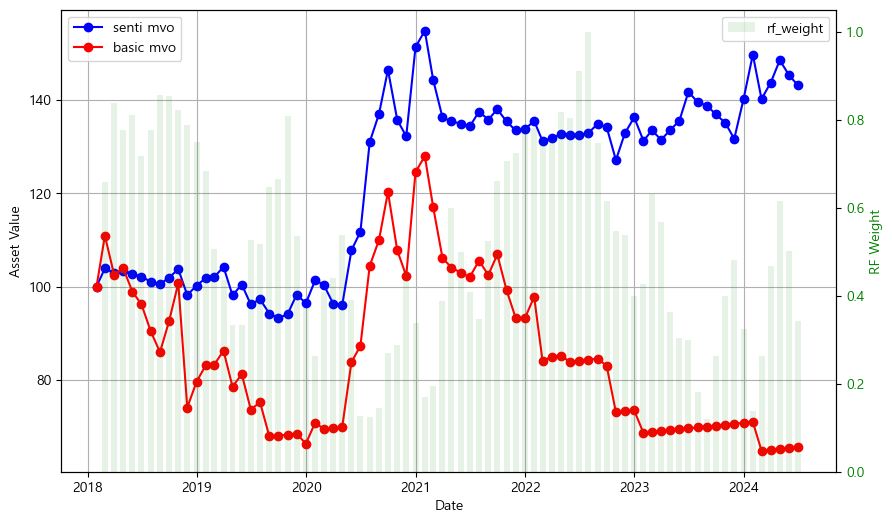

In [11]:
import matplotlib.pyplot as plt
asset_values1 = [100]  # 초기 자산 값 100
for rv in rv_list[:]:
    asset_values1.append(asset_values1[-1] * (rv/100 +1))
print(asset_values1[-1])
asset_values2 = [100]  # 초기 자산 값 100
for rv in rv_list2:
    asset_values2.append(asset_values2[-1] * (rv/100 + 1))

# asset_values3 = [100]  # 초기 자산 값 100
# for rv in kospi['Monthly_Return'][1:]:
#     asset_values3.append(asset_values3[-1] * (rv + 1))

# 날짜 생성 (rv_list 길이에 맞게)
dates = pd.date_range(start='2018-01-31', periods=len(asset_values1), freq='M')
# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 y축
ax1.plot(dates, asset_values1[:], marker='o', linestyle='-', color='b', label='senti mvo')
ax1.plot(dates, asset_values2[:], marker='o', linestyle='-', color='r', label='basic mvo')
# ax1.plot(portfolio_df['date'], portfolio_df['portfolio_value'],marker='o', linestyle='-',color='r', label='black_litterman')
# ax1.plot(dates, asset_values3[1:], marker='o', linestyle='-', color='g', label='kospi')
ax1.set_xlabel('Date')
ax1.set_ylabel('Asset Value', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# 두 번째 y축
ax2 = ax1.twinx()
bar_width = 20  # 바의 너비를 조정
ax2.bar(dates[1:], df_merged['rf_weight'], alpha=0.1, color='g', width=bar_width, label='rf_weight')
ax2.set_ylabel('RF Weight', color='g')
ax2.tick_params(axis='y', labelcolor='g')
# 제목 및 범례 추가
# fig.suptitle('Asset Value Over Time[블룸버그]')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 그리드 추가
ax1.grid(True)

plt.show()

C:\Users\82107\AppData\Local\Temp\ipykernel_34732\832562292.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2018-01-01', periods=77, freq='M')


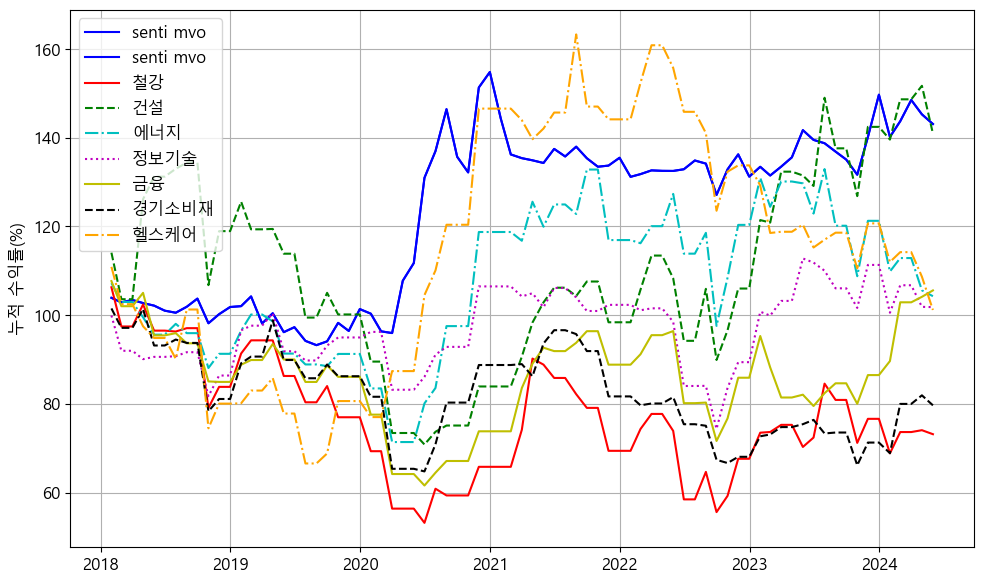

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_return.index = pd.to_datetime(df_return.index)
dates = pd.date_range(start='2018-01-01', periods=77, freq='M')
df_return_selected = df_return.reindex(dates).fillna(0)  # NaN은 0으로 대체

initial_value = 100

cumulative_returns = initial_value * (1 + df_return_selected).cumprod()

plt.rcParams.update({'font.size': 12})
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(dates, asset_values1[1:], linestyle='-', color='b', label='senti mvo')
ax1.plot(dates, asset_values1[1:], linestyle='-', color='b', label='senti mvo')

line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
colors = ['r', 'g', 'c', 'm', 'y', 'k', 'orange']

for i, asset in enumerate(cumulative_returns.columns):
    ax1.plot(cumulative_returns.index, cumulative_returns[asset],
             linestyle=line_styles[i % len(line_styles)],
             color=colors[i % len(colors)],
             label=asset)

ax1.set_ylabel('누적 수익률(%)')
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=0)
ax1.legend(loc='best')
plt.tight_layout()
plt.grid(True)
plt.show()

평가 함수

In [14]:
import numpy as np
import pandas as pd

# 샤프 비율 계산 함수
def calculate_sharpe_ratio(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate
    annualized_excess_return = np.mean(excess_returns) * 12
    annualized_std_dev = np.std(excess_returns) * np.sqrt(12)
    sharpe_ratio = annualized_excess_return / annualized_std_dev
    return sharpe_ratio

# 최대 낙폭 계산 함수
def calculate_max_drawdown(asset_values):
    peak = np.maximum.accumulate(asset_values)
    drawdown = (asset_values - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

# 정보비율 계산 함수
def calculate_information_ratio(returns, benchmark_returns):
    active_returns = returns - benchmark_returns
    tracking_error = np.std(active_returns) * np.sqrt(12)
    annualized_active_return = np.mean(active_returns) * 12
    information_ratio = annualized_active_return / tracking_error
    return information_ratio

# 소티노 비율 계산 함수
def calculate_sortino_ratio(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate
    annualized_excess_return = np.mean(excess_returns) * 12
    downside_deviation = np.std(excess_returns[excess_returns < 0]) * np.sqrt(12)
    sortino_ratio = annualized_excess_return / downside_deviation
    return sortino_ratio


asset_values2 = [100]
for rv in rv_list2:
    asset_values2.append(asset_values2[-1] * (rv / 100 + 1))

# 자산 가치 시리즈로 변환
asset_values1 = np.array(asset_values1)
asset_values2 = np.array(asset_values2)

# 수익률 계산
returns1 = np.diff(asset_values1) / asset_values1[:-1]
returns2 = np.diff(asset_values2) / asset_values2[:-1]

# 샤프 비율 계산
sharpe_ratio1 = calculate_sharpe_ratio(returns1)
sharpe_ratio2 = calculate_sharpe_ratio(returns2)

# 최대 낙폭 계산
max_drawdown1 = calculate_max_drawdown(asset_values1)
max_drawdown2 = calculate_max_drawdown(asset_values2)

# 정보비율 계산 (benchmark_returns는 비교할 벤치마크 수익률)
benchmark_returns = returns2  # 예시로 returns2를 벤치마크로 사용
information_ratio1 = calculate_information_ratio(returns1, benchmark_returns)
# information_ratio2 = calculate_information_ratio(returns2, benchmark_returns)

# 소티노 비율 계산
sortino_ratio1 = calculate_sortino_ratio(returns1)
sortino_ratio2 = calculate_sortino_ratio(returns2)

print(f"Sharpe Ratio (Senti MVO): {sharpe_ratio1:.4f}")
print(f"Sharpe Ratio (Basic MVO): {sharpe_ratio2:.4f}")
print(f"Maximum Drawdown (Senti MVO): {max_drawdown1:.4f}")
print(f"Maximum Drawdown (Basic MVO): {max_drawdown2:.4f}")
print(f"Information Ratio (Senti MVO): {information_ratio1:.4f}")
# print(f"Information Ratio (Basic MVO): {information_ratio2:.4f}")
print(f"Sortino Ratio (Senti MVO): {sortino_ratio1:.4f}")
print(f"Sortino Ratio (Basic MVO): {sortino_ratio2:.4f}")


Sharpe Ratio (Senti MVO): 0.4551
Sharpe Ratio (Basic MVO): -0.1440
Maximum Drawdown (Senti MVO): -0.1790
Maximum Drawdown (Basic MVO): -0.4932
Information Ratio (Senti MVO): 0.6896
Sortino Ratio (Senti MVO): 0.9280
Sortino Ratio (Basic MVO): -0.1932


샤프비율 2

In [15]:
import pandas as pd
import numpy as np

# 1. 각 자산의 월별 수익률 계산
returns = cumulative_returns.pct_change().dropna()
asset_values2_series = pd.Series(asset_values2)
returns2 = asset_values2_series.pct_change().dropna()
returns2 = returns2.reindex(returns.index).fillna(0)

# 4. 결과를 저장할 데이터프레임 초기화
metrics = pd.DataFrame(columns=['Sharpe Ratio', 'Max Drawdown', 'Sortino Ratio', 'Information Ratio'])

# 5. 각 자산에 대해 지표 계산
for asset in returns.columns:
    asset_returns = returns[asset]
    asset_values = cumulative_returns[asset]

    # 샤프 비율 계산
    sharpe = calculate_sharpe_ratio(asset_returns)

    # 최대 낙폭 계산
    mdd = calculate_max_drawdown(asset_values)

    # 소르티노 비율 계산
    sortino = calculate_sortino_ratio(asset_returns)

    # 정보 비율 계산
    info_ratio = calculate_information_ratio(asset_returns, returns2)

    # 결과 저장
    metrics.loc[asset] = [sharpe, mdd, sortino, info_ratio]

# 결과 출력
metrics


,Sharpe Ratio,Max Drawdown,Sortino Ratio,Information Ratio
철강,-0.092583,-0.499644,-0.123320,-0.092583
건설,0.260050,-0.472848,0.339828,0.260050
에너지,0.091477,-0.334142,0.130624,0.091477
정보기술,0.106966,-0.301682,0.127444,0.106966
금융,0.083251,-0.427963,0.101900,0.083251
경기소비재,-0.095183,-0.361898,-0.107747,-0.095183
헬스케어,0.064095,-0.399711,0.086053,0.064095
